In [318]:
!pip install netCDF4
!pip install keras-rectified-adam
!pip install kornia
import itertools

from scipy import linalg
import matplotlib.pyplot as plt 
import matplotlib as mpl



import netCDF4
from netCDF4 import Dataset
import pathlib


import numpy as np
import pandas as pd
import seaborn as sns

import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.utils.data import Dataset, DataLoader

import xarray as xr

from datetime import date
import datetime
import kornia

In [319]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from time import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline

from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn import mixture
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler


!pip install skorch
from skorch import NeuralNetClassifier
from sklearn.model_selection import cross_val_score

# Load the dataset (2004 period)



In [320]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [321]:
ds = xr.open_dataset("/content/gdrive/My Drive/dataset/SST_SSH_U_V_SLA_global_2004.nc")
print(ds.sizes)
ds

Frozen(SortedKeysDict({'lon': 1440, 'lat': 720, 'time': 366}))


<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 366)
Coordinates:
  * lon      (lon) float32 -179.875 -179.625 -179.375 ... 179.625 179.875
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * time     (time) datetime64[ns] 2004-01-01T12:00:00 ... 1981-01-01
Data variables:
    SST      (time, lat, lon) float32 ...
    SSH      (time, lon, lat) float32 ...
    U        (time, lon, lat) float32 ...
    V        (time, lon, lat) float32 ...
    SLA      (time, lon, lat) float32 ...
Attributes:
    CDI:                    Climate Data Interface version 1.5.3 (http://code...
    Conventions:            CF-1.0
    history:                Mon Jul 21 17:26:58 2014: cdo merge SST_SSH_U_V_g...
    title:                  Analysed foundation sea surface temperature, global
    DSD_entry_id:           REMSS-L4LRfnd-GLOB-tmi_amsre_OI
    references:             none
    source_data:            TMI-REMSS,AMSRE-REMSS
    contact:                support@remss.com
    GDS_version_id:         GDS-v1.0-rev1.6
    netcdf_version_id:      3.5.0
    creation_date:          2010-08-04
    product_version:        v03
    spatial_resolution:     25 km
    start_date:             2003-12-30
    start_time:             00:00:00 UTC
    stop_date:              2004-01-03
    stop_time:              23:59:59 UTC
    southernmost_latitude:  -89.875
    northernmost_latitude:  89.875
    westernmost_longitude:  -179.875
    easternmost_longitude:  179.875
    file_quality_index:     1
    comment:                www.remss.com for more infomation on product
    CDO:                    Climate Data Operators version 1.5.3 (http://code...

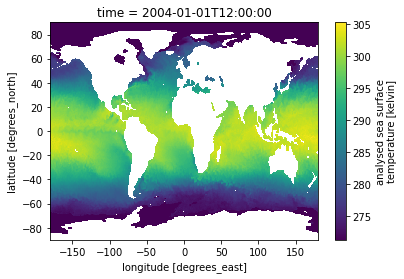

In [322]:
SST = ds.SST
SST[0].plot()

## Definition of the time window and the region

<xarray.DataArray 'SSH' (time: 120, lat: 56, lon: 56)>
[376320 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 155.125 155.375 155.625 ... 168.375 168.625 168.875
  * lat      (lat) float32 20.125 20.375 20.625 20.875 ... 33.375 33.625 33.875
  * time     (time) datetime64[ns] 2004-01-01T12:00:00 ... 2004-04-29T12:00:00
Attributes:
    long_name:        H
    units:            cm
    _CoordinateAxes:  time NbLongitudes NbLatitudes

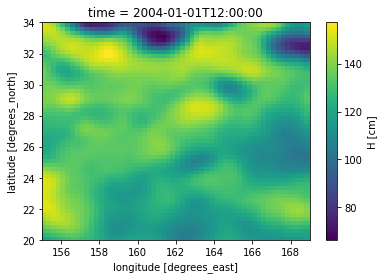

In [323]:
time_window = 120
win_x = 56
win_y = 56
lon_min = 155
lon_max = 169
lat_min = 20
lat_max = 34
ds_cut = ds.sel(lon=slice(lon_min,lon_max),lat=slice(lat_min,lat_max))
ds_cut = ds_cut.isel(time=slice(0,time_window))
SSH = ds_cut.SSH.transpose('time','lat','lon')
SSH[0].plot()
SSH

### Plot SST

SST shape: (56, 56)


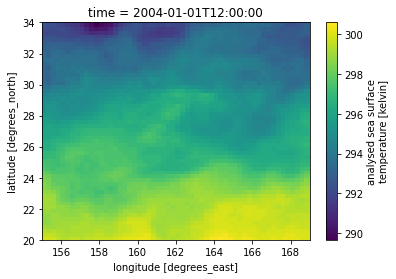

In [324]:
SST = ds_cut.SST
print('SST shape: {}'.format(SST[0].shape))
SST[0].plot()

### Plot SSH

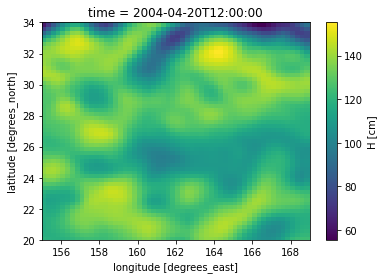

In [325]:
SSH[110].plot()

### Plot current U V

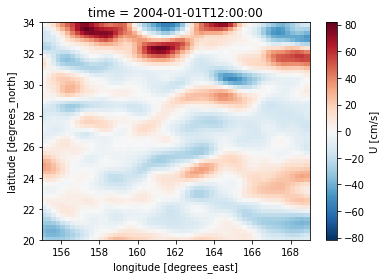

In [326]:
U = ds_cut.U.transpose('time','lat','lon')
V = ds_cut.V.transpose('time','lat','lon') 
U[0].plot()

### Computation of the min/max of all the variable for normalization

In [327]:
df = ds_cut.to_dataframe()
SST_x_max = df.SST.describe(include='all').loc['max']
SST_x_min = df.SST.describe(include='all').loc['min']
SSH_x_max = df.SSH.describe(include='all').loc['max']
SSH_x_min = df.SSH.describe(include='all').loc['min']
U_x_max = df.U.describe(include='all').loc['max']
U_x_min = df.U.describe(include='all').loc['min']
V_x_max = df.V.describe(include='all').loc['max']
V_x_min = df.V.describe(include='all').loc['min']
df.describe()

,SST,SSH,U,V,SLA
count,376320.000000,376320.000000,376320.000000,376320.000000,376320.000000
mean,294.444763,123.406593,1.784984,-1.205104,0.693712
std,3.229000,14.513341,18.716164,15.682958,12.343619
min,285.899994,34.801949,-68.715294,-91.202873,-54.385845
25%,291.899994,116.395327,-10.043820,-9.791287,-7.599299
50%,294.600006,125.842899,-0.759903,-0.727630,1.129859
75%,297.750000,132.845219,10.827543,7.854344,8.158774
max,301.199982,157.254807,97.580177,101.168152,51.724899


In [328]:
for v in ds_cut.data_vars:
    print('{:>10}: {}'.format(v, ds[v].attrs['long_name']))

       SST: analysed sea surface temperature
       SSH: H
         U: U
         V: V
       SLA: H


#Normalization

In [0]:
def pad_with(vector, pad_width, iaxis, kwargs):
  pad_value = kwargs.get('padder', 10)
  vector[:pad_width[0]] = pad_value
  vector[-pad_width[1]:] = pad_value

def normalize_negative_one(img):
    normalized_input = (img - np.amin(img)) / (np.amax(img) - np.amin(img))
    return 2*normalized_input - 1  

In [330]:
from sklearn.feature_extraction import image


#fill NaN values with the mean of the SSH, SST, U, V mean
SSTf = SST.fillna(SST.mean())
#SSTf = np.pad(SSTf, padding, pad_with, padder=SSTf.mean())
print('SST shape: {}'.format(SSTf.shape))


SSHf = SSH.fillna(SSH.mean())
print('SSH shape: {}'.format(SSHf.shape))

Uf = U.fillna(U.mean())
print('U shape: {}'.format(Uf.shape))

Vf = V.fillna(V.mean())
print('V shape: {}'.format(Vf.shape))

SST_n = np.empty(([time_window, win_x,win_y]))
SSH_n = np.empty(([time_window, win_x,win_y]))
U_n = np.empty(([time_window, win_x,win_y]))
V_n = np.empty(([time_window, win_x,win_y]))
#for each time step, compute patches of size (13x13), flatten them in 1D and concatenate them in SSH_patches, SST_patches, U_patches, V_patches
#output : 1D array of SSH patchs
for i in range(ds_cut.time.shape[0]):
  if (i%50 == 0):
    print("Round : "+ str(i))
  
  #print(SSH.shape[0])
  #for h in range(SSH[0].shape[0]):
  SSH_n[i] = (SSHf[i] - SSH_x_min)/(SSH_x_max-SSH_x_min)
  U_n[i] = (Uf[i] - U_x_min)/(U_x_max-U_x_min)
  V_n[i] = (Vf[i] - V_x_min)/(V_x_max-V_x_min)
  SST_n[i] = (SSTf[i] - SST_x_min)/(SST_x_max-SST_x_min)
  

  #print("SST " + str(SST[i].shape))




SST shape: (120, 56, 56)
SSH shape: (120, 56, 56)
U shape: (120, 56, 56)
V shape: (120, 56, 56)
Round : 0
Round : 50
Round : 100


## Definition of the function that evaluate the accuracy of the model on a dataset 

In [0]:
def calculate_accuracy(Y_hat, Y):
    _, Y_hat = Y_hat.max(1)
    print("Y : " + str(Y.shape))
    print("Y_hat : " + str(Y_hat.shape))
    trues = (Y_hat == Y[:,0,:,:].long()) * 1
    trues = trues.cpu().numpy()

    accuracy = np.mean(trues)

    return accuracy, Y_hat.cpu().numpy(), Y.cpu().numpy()


def evaluate_set(model, data_loader, set_name):
    model.eval()

    average_accuracy = 0
    n_samples = 0

    y_true = []
    y_pred = []

    for batch_idx, batch in enumerate(data_loader):
        print(str(batch_idx) + " / " + str(len(data_loader)))
        X = batch[0]
        Y = batch[1]

        batch_size = Y.shape[0]
        n_samples += batch_size

        out = model(X)

        accuracy, Y_hat, Y = calculate_accuracy(out, Y)
        average_accuracy += accuracy * batch_size

        y_true.append(Y)
        y_pred.append(Y_hat)

    return average_accuracy / n_samples, y_true, y_pred

## Definition of the model

In [0]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = torch.nn.Sequential(torch.nn.Conv2d(3, 3, kernel_size=3, stride=1, dilation = 1, padding=1))
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            torch.nn.Conv2d(3, 3, kernel_size=3, stride=1, dilation = 1, padding=1),
            ReLU(inplace=True)
        )

        
    def forward(self, x):
      out1 = self.layer1(x)
      #out1 = self.cnn_layers(x)
      #out2 = self.fc1(out1)
      return out1    



# Data pre-processing and training

(56, 56)
U : (120, 56, 56)
V : (120, 56, 56)
SSH : (120, 56, 56)
56
Y shape :(120, 56, 56, 3)
<class 'torch.Tensor'>
X_train : torch.Size([70, 3, 56, 56])
y_train : torch.Size([70, 3, 56, 56])
X_val : torch.Size([20, 3, 56, 56])
y_val : torch.Size([20, 3, 56, 56])
X_test : torch.Size([30, 3, 56, 56])
y_test : torch.Size([30, 3, 56, 56])
Epoch : 0
torch.DoubleTensor
torch.DoubleTensor
output : torch.Size([70, 3, 56, 56])
labels : torch.Size([70, 3, 56, 56])
[1,     1] loss: 0.490
laplacian : tensor(0.0166, dtype=torch.float64, grad_fn=<AddBackward0>)
0 / 1
Y : torch.Size([20, 3, 56, 56])
Y_hat : torch.Size([20, 56, 56])
validation accuracy :0.20065369897959187
Epoch : 1
torch.DoubleTensor
torch.DoubleTensor
output : torch.Size([70, 3, 56, 56])
labels : torch.Size([70, 3, 56, 56])
[2,     1] loss: 0.357
laplacian : tensor(0.0201, dtype=torch.float64, grad_fn=<AddBackward0>)
0 / 1
Y : torch.Size([20, 3, 56, 56])
Y_hat : torch.Size([20, 56, 56])
validation accuracy :0.20894451530612246
Epo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


0 / 1
Y : torch.Size([20, 3, 56, 56])
Y_hat : torch.Size([20, 56, 56])
validation accuracy :0.3240752551020408
Epoch : 22
torch.DoubleTensor
torch.DoubleTensor
output : torch.Size([70, 3, 56, 56])
labels : torch.Size([70, 3, 56, 56])
[23,     1] loss: 0.244
laplacian : tensor(0.0255, dtype=torch.float64, grad_fn=<AddBackward0>)
0 / 1
Y : torch.Size([20, 3, 56, 56])
Y_hat : torch.Size([20, 56, 56])
validation accuracy :0.2504304846938776
Epoch : 23
torch.DoubleTensor
torch.DoubleTensor
output : torch.Size([70, 3, 56, 56])
labels : torch.Size([70, 3, 56, 56])
[24,     1] loss: 0.241
laplacian : tensor(0.0248, dtype=torch.float64, grad_fn=<AddBackward0>)
0 / 1
Y : torch.Size([20, 3, 56, 56])
Y_hat : torch.Size([20, 56, 56])
validation accuracy :0.20191326530612247
Epoch : 24
torch.DoubleTensor
torch.DoubleTensor
output : torch.Size([70, 3, 56, 56])
labels : torch.Size([70, 3, 56, 56])
[25,     1] loss: 0.238
laplacian : tensor(0.0241, dtype=torch.float64, grad_fn=<AddBackward0>)
0 / 1
Y :

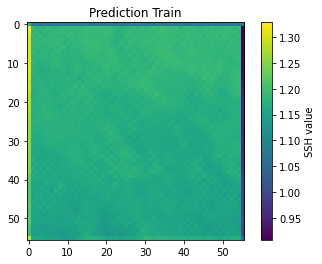

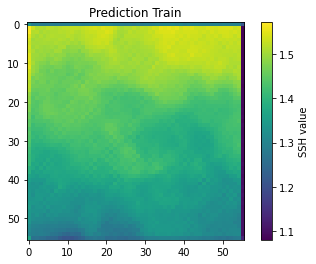

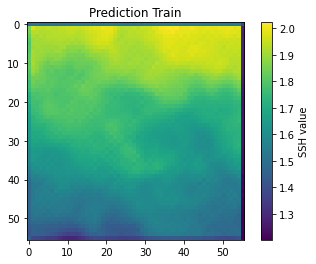

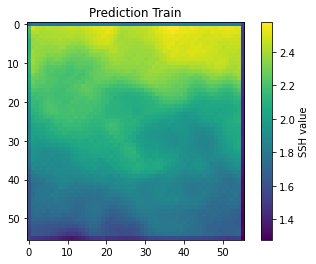

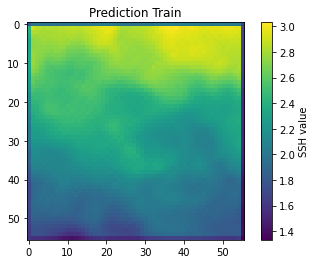

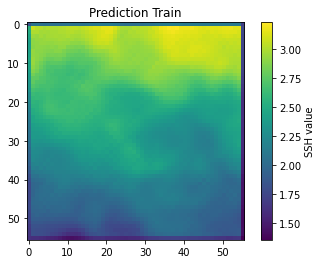

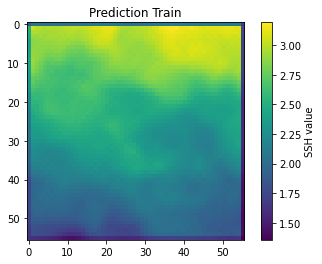

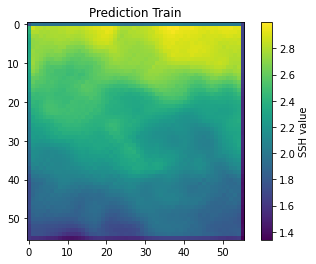

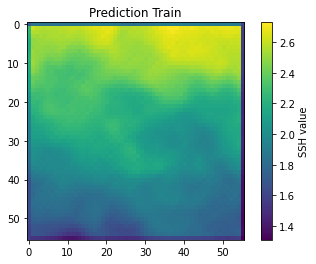

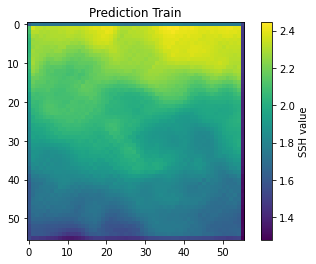

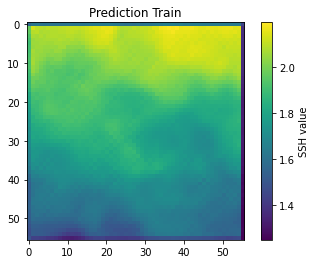

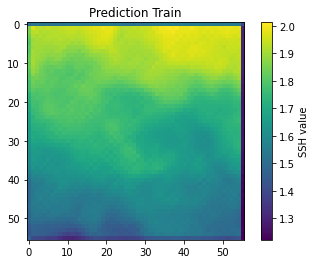

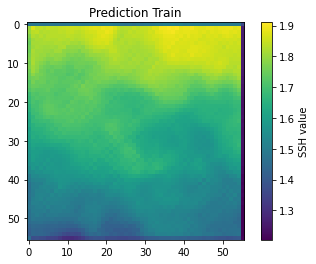

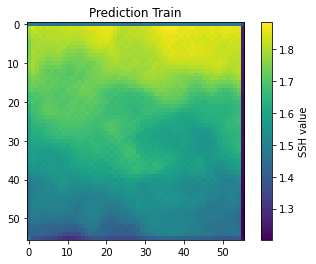

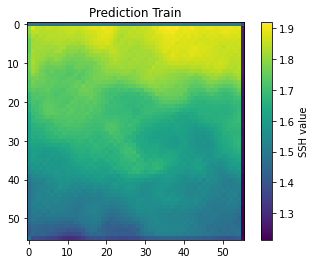

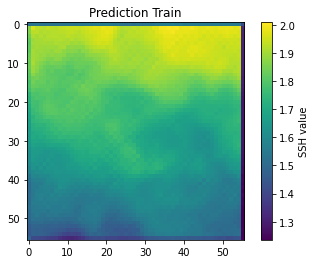

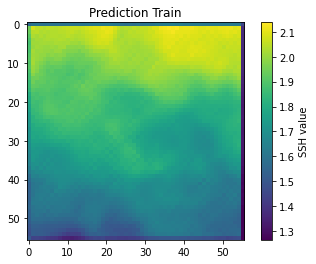

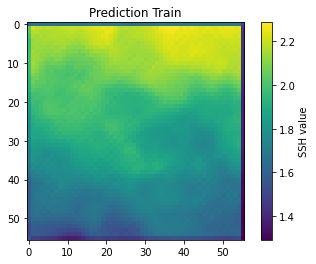

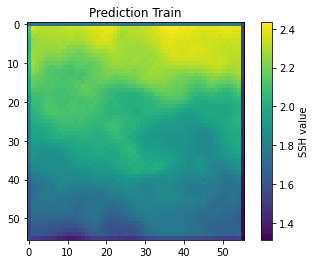

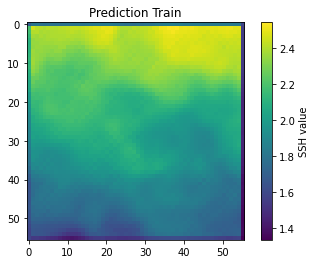

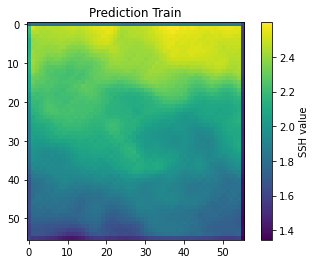

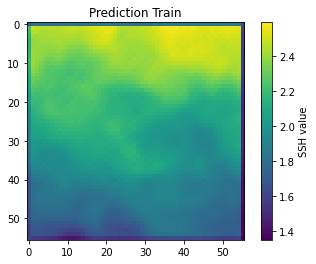

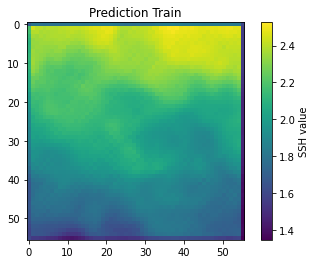

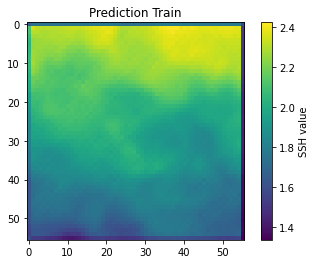

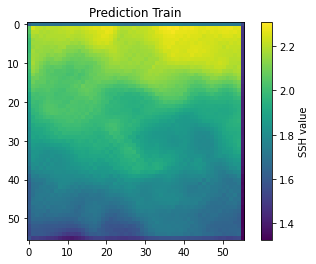

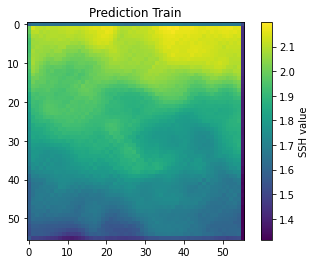

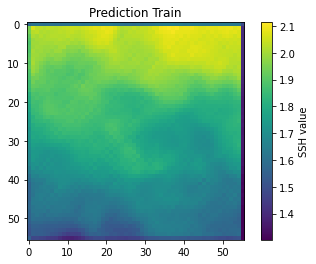

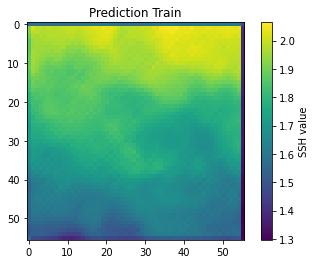

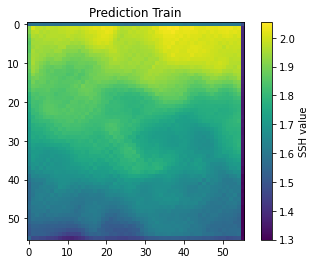

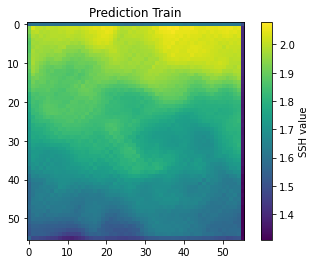

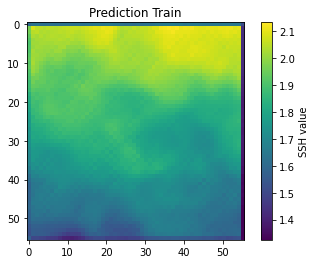

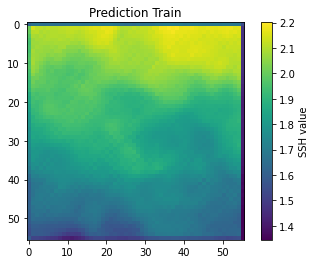

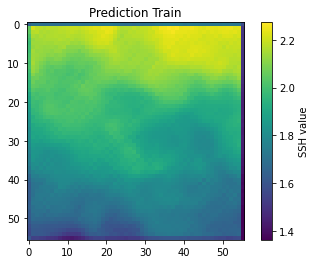

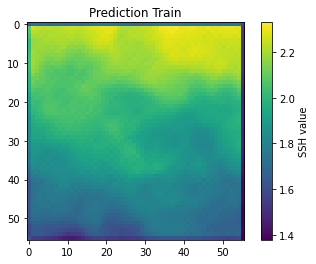

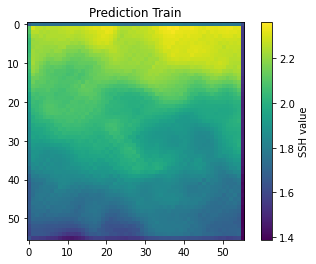

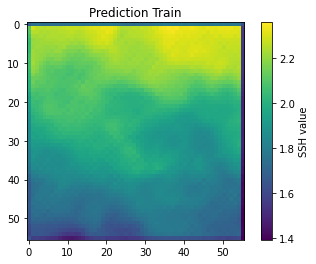

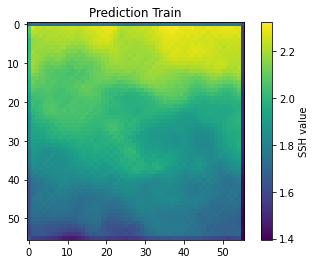

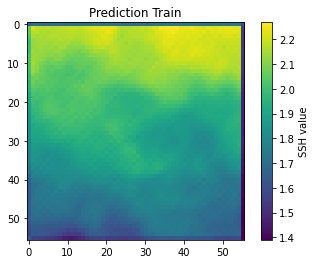

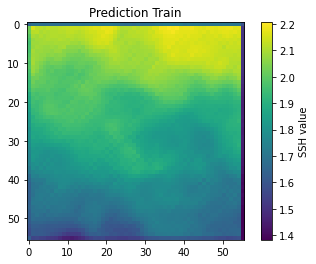

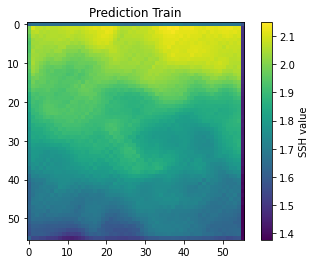

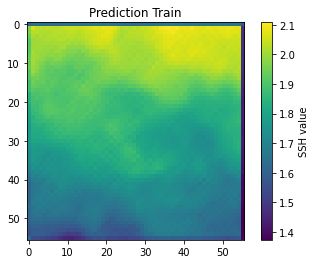

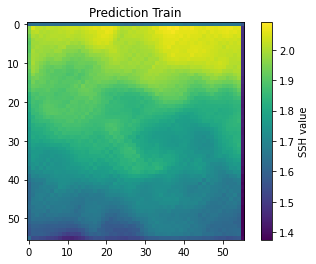

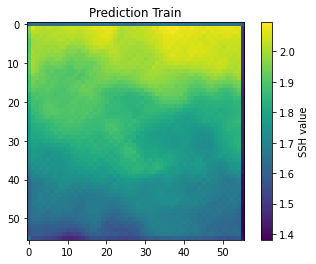

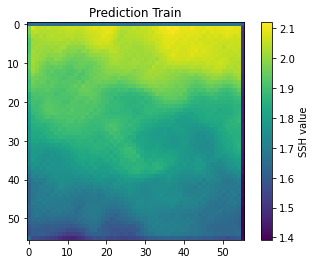

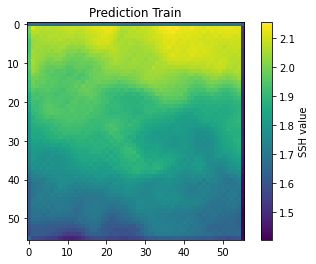

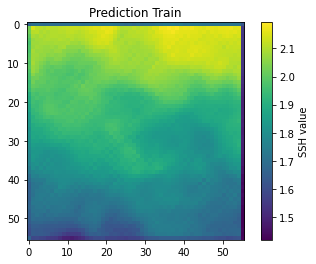

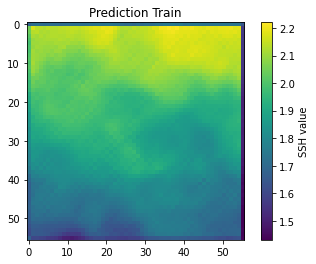

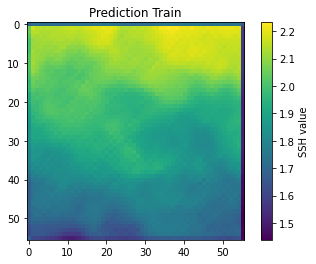

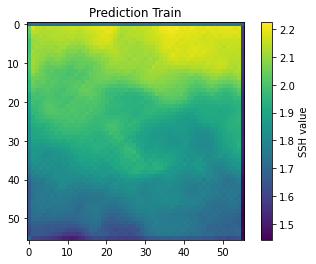

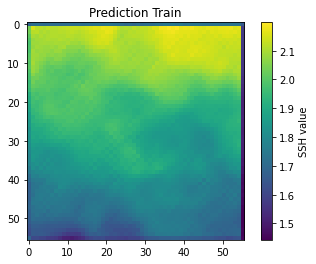

In [333]:
#X = np.stack((SST_patches,SSH, U, V))
X= SST_n
print(X[0].shape)

BATCH_SIZE = 90

print("U : " + str(U_n.shape))
print("V : " + str(V_n.shape))
print("SSH : " + str(SSH_n.shape))
y = np.stack((SSH_n, U_n, V_n)) 
y_nb_feature = y.shape[0]
#print magique
print(SST.shape[2])

y = y.reshape((time_window, SSH_n.shape[1], SSH_n.shape[2],y_nb_feature))
print("Y shape :" + str(y.shape))
# Split the data into training/validation/testing sets
X_train_np_1 = X[:90]
X_train_np = X[:70]
X_val_np = X[-20:]
X_test_np = X[-30:]
#X_train_rsp = X_train_np.reshape((190, 1, 72, 48))


#Reshaping and extension of the dimension from 1 to 3

X_train_exp = np.expand_dims(X_train_np,1)
X_train_dup = torch.from_numpy(X_train_exp).double()
X_train = X_train_dup.repeat(1,3,1,1)

X_val_exp = np.expand_dims(X_val_np,1)
X_val_dup = torch.from_numpy(X_val_exp).double()
X_val = X_val_dup.repeat(1,3,1,1)

X_test_exp = np.expand_dims(X_test_np,1)
X_test_dup = torch.from_numpy(X_test_exp).double()
X_test = X_test_dup.repeat(1,3,1,1)

print(type(X_train))
# Split the targets into training/validation/testing sets
y_train_np_1 = y[:90]
y_train_np = y_train_np_1[:70]
y_val_np = y[-20:]
y_test_np = y[-30:]

#Reshaping

y_train_rp = y_train_np.reshape((70, 3, win_x, win_y))
y_val_rp = y_val_np.reshape((20, 3, win_x, win_y))
y_test_rp = y_test_np.reshape((30, 3, win_x, win_y))

y_train = torch.from_numpy(y_train_rp).double()
y_val = torch.from_numpy(y_val_rp).double()
y_test = torch.from_numpy(y_test_rp).double()

#train = torch.utils.data.TensorDataset(X_train,y_train)

train_loader = DataLoader([X_train,y_train], batch_size=70, shuffle=False)
val_loader = DataLoader([X_val,y_val], batch_size=20, shuffle=False)
test_loader = DataLoader([X_test,y_test], batch_size=30, shuffle=False)

print("X_train : " + str(X_train.shape))
print("y_train : " + str(y_train.shape))
print("X_val : " + str(X_val.shape))
print("y_val : " + str(y_val.shape))
print("X_test : " + str(X_test.shape))
print("y_test : " + str(y_test.shape))


# Hyperparameters
num_epochs = 50
batch_size = 70
learning_rate = 0.01


#torch.manual_seed(RANDOM_SEED)

model = ConvNet()
model = model.double()

# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(train_loader)
loss_list = []
acc_list = []
lap_list = []
val_list = []
for epoch in range(num_epochs):
  running_loss = 0.0
  running_lap = 0.0
  print("Epoch : " + str(epoch))
  for i, (images, labels) in enumerate(train_loader):
    # Run the forward pass
    print(images.type())
    print(labels.type())
    outputs = model(images)
    print("output : " + str(outputs.shape))
    print("labels : " + str(labels.shape))
    loss = torch.sqrt(criterion(outputs, labels))

    lap_out = kornia.filters.laplacian(outputs,3)
    lap_lab = kornia.filters.laplacian(labels,3)
    lap = torch.sqrt(criterion(lap_out, lap_lab))

    loss_list.append(loss.item())
    lap_list.append(lap)

    # Backprop and perform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_lap += lap
    if i % 90 == 0: 
      print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss ))
      print('laplacian : ' + str(running_lap))
      plt.figure()
      plt.title('Prediction Train')

      plt.imshow(torch.exp(outputs[0,0,:,:]).detach().cpu(), label='OUTPUT')
      
      plt.colorbar(label = 'SSH value')
      running_loss = 0.0

      with torch.no_grad():
            validation_accuracy, _, _ = evaluate_set(model,
                                                     val_loader,
                                                     "VAL")
      print("validation accuracy :" + str(validation_accuracy))
      val_list.append(validation_accuracy) 





## Plot of the prediction, the input, the label, the loss (RMSE), the cross validation and the RMSE of the laplacian

In [0]:
def print_map(map,type,title):
  if(type == "SSH"):
    out_norm = map * (SSH_x_max-SSH_x_min) + SSH_x_min
  if(type == "SST"):
    out_norm = map * (SST_x_max-SST_x_min) + SST_x_min
  if(type == "U"):
    out_norm = map * (U_x_max-U_x_min) + U_x_min
  if(type == "V"):
    out_norm = map * (V_x_max-V_x_min) + V_x_min
  
  out_nump = out_norm.detach().cpu().numpy()
  out_f = xr.DataArray(out_nump)
  print(out_f)
  print(title)
  out_f.plot()

def print_lineplot(list_val,title):
  plt.figure()
  plt.title(title)
  plt.plot(np.array(list_val), 'r')


<xarray.DataArray (dim_0: 56, dim_1: 56)>
array([[ 98.79119637, 101.07465003, 101.43106932, ..., 102.24171741,
        101.61961027,  96.53476435],
       [122.20542495, 128.63903877, 126.90007217, ..., 129.08708613,
        129.52913325,  90.5577603 ],
       [121.90635013, 126.57725225, 126.87322548, ..., 129.471951  ,
        128.81754604,  90.28187287],
       ...,
       [ 94.14805751,  96.89341476,  96.56821084, ...,  99.3681503 ,
         99.34746322,  80.5494886 ],
       [ 93.64082653,  96.85927583,  96.48939176, ...,  99.14206433,
         99.65828474,  80.35847056],
       [ 99.13943304,  93.10906878,  93.33577257, ...,  94.86981641,
         95.33715992,  80.79632462]])
Dimensions without coordinates: dim_0, dim_1
**pred_train**


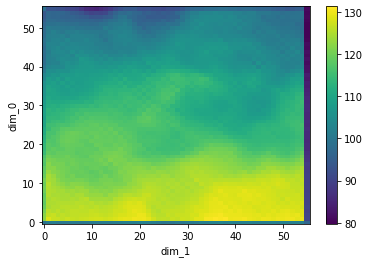

In [335]:
print_map(outputs[0,0,:,:],"SSH","**pred_train**")

<xarray.DataArray (dim_0: 56, dim_1: 56)>
array([[299.8500061 , 299.8500061 , 299.8500061 , ..., 300.14999399,
        300.00000005, 300.00000005],
       [299.54998812, 299.69998206, 299.54998812, ..., 300.00000005,
        300.00000005, 300.00000005],
       [299.39999418, 299.25000023, 299.39999418, ..., 300.00000005,
        299.8500061 , 299.8500061 ],
       ...,
       [292.04998771, 292.04998771, 292.04998771, ..., 292.79998798,
        292.94998147, 292.94998147],
       [292.19998165, 292.19998165, 292.19998165, ..., 292.64999404,
        292.79998798, 292.94998147],
       [292.50000009, 292.35000615, 292.35000615, ..., 292.50000009,
        292.64999404, 292.94998147]])
Dimensions without coordinates: dim_0, dim_1
**input_train**


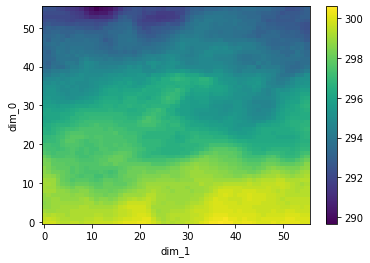

In [336]:
print_map(images[0,0,:,:],"SST","**input_train**")

<xarray.DataArray (dim_0: 56, dim_1: 56)>
array([[120.24077736, 121.10297977, 123.19649014, ..., 115.99258572,
        116.20432272, 116.61662962],
       [125.01809255, 126.39678435, 128.61032281, ..., 118.18039606,
        117.96331636, 118.01637834],
       [130.41035738, 132.22119411, 134.52421536, ..., 121.56157541,
        120.94267713, 120.56426566],
       ...,
       [148.84052697, 148.98899833, 148.96687579, ..., 101.47525898,
        102.05340099, 104.416637  ],
       [151.34559977, 150.45033398, 148.42196503, ..., 107.33989221,
        108.29265762, 111.46492459],
       [151.73640453, 149.81019631, 145.35145737, ..., 112.26462773,
        112.79610147, 115.95226737]])
Dimensions without coordinates: dim_0, dim_1
**label_train**


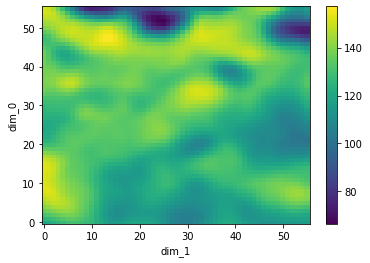

In [337]:
print_map(y_train[0,0,:,:],"SSH","**label_train**")

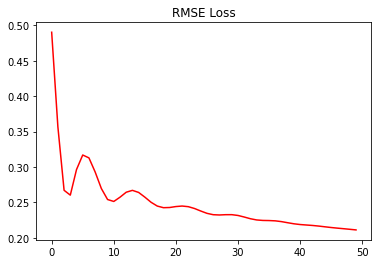

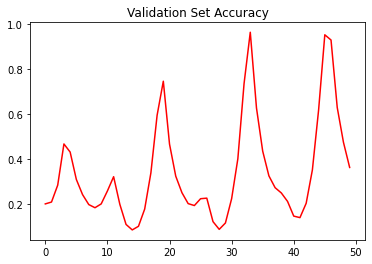

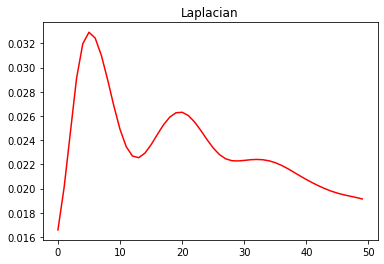

In [338]:
print_lineplot(loss_list,"RMSE Loss")
print_lineplot(val_list,"Validation Set Accuracy")
print_lineplot(lap_list,"Laplacian")

### Compute the accuracy of the model on the test set

In [339]:
with torch.no_grad():
      validation_accuracy, _, _ = evaluate_set(model,test_loader,"VAL")
      print("validation accuracy :" + str(validation_accuracy))


0 / 1
Y : torch.Size([30, 3, 56, 56])
Y_hat : torch.Size([30, 56, 56])
validation accuracy :0.39221938775510207
